Suppl. Fig. 20: Memory performance comparison
----

In this notebook, we plot the multi-core memory performance, as well as produce Suppl. Tab. 2.

# Preliminaries

## Dependencies

1. Please consult the [analysis_files/README.md](analysis_files/README.md) on how to run the memory performance benchmarks.

## Import packages

In [1]:
# import standard packages
from pathlib import Path
from collections import defaultdict
import os
import sys
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Set up paths

In [2]:
sys.path.insert(0, "../..")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

## Set global parameters

In [3]:
root = DATA_DIR / 'benchmarking' / 'memory_analysis'
alg = "algorithm"
pretty_names = {
    'fateid': 'FateID',
    'stemnet': 'STEMNET',
    'palantir': 'Palantir',
    'ap': 'CellRank (lin. probs.)',
    'macro': 'CellRank (macrostates)',
}

## Load the data

In [6]:
res = {
    'fateid': defaultdict(dict),
    'ap': defaultdict(dict),
    'macro': defaultdict(dict),
    'palantir': defaultdict(dict),
    'stemnet': defaultdict(dict),
    'kernel': defaultdict(dict),
}

for key in ['fateid', 'gpcca', 'palantir', 'stemnet']:
    for fname in os.listdir(root / key):
        if not fname.endswith('.txt') and not fname.endswith('.pickle'):
            continue
        name = fname.split('.')[0]
        rest = name.split('_')
        if len(rest) == 3:
            rest = rest[1:]
            
        size, split = map(int, rest)
        path = root / key / fname
                
        if fname.endswith('.pickle'):
            with open(path, 'rb') as fin:
                data = pickle.load(fin)
                if 'ap_mem' in data:
                    assert key == 'gpcca'
                    res['kernel'][size][split] = max(data['kernel_mem'])
                    res['macro'][size][split] = max(data['macro_mem'])
                    res['ap'][size][split] = max(data['ap_mem'])
                else:
                    assert key != 'gpcca'
                    res[key][size][split] = max(data)
        else:
            with open(path, 'r') as fin:
                data = fin.read().strip().split('\n')[-1]
                res[key][size][split] = float(data.split(' ')[-1])

### Clean the data

In [7]:
dfs = []
for key in res.keys():
    df = pd.DataFrame(res[key])
    df.sort_index(axis=0, inplace=True)
    df.sort_index(axis=1, inplace=True)
    df['algorithm'] = key
    dfs.append(df)
    
df = pd.concat(dfs, axis=0)
# sum up memory for kernel and macrostates
km = df[df[alg] == 'kernel'].select_dtypes(exclude='category') +\
    df[df[alg] == 'macro'].select_dtypes(exclude='category')
km[alg] = 'macro'

df = df[df[alg] != 'kernel']
df[df[alg] == "macro"] = km
df[alg] = df[alg].astype('category')

df[alg].cat.rename_categories(pretty_names, inplace=True)
df[alg].cat.reorder_categories([pretty_names[c] for c in
                                ['ap', 'macro', 'fateid', 'palantir', 'stemnet']], inplace=True)

### Convert to GiB

In [8]:
tmp = df.select_dtypes(exclude='category').divide(1024)  # work in GiB instead of MiB
tmp[alg] = df[alg]
df = tmp

## Define utility functions

In [9]:
def plot(df):

    tmp = pd.melt(df, id_vars=[alg], var_name='size', value_name='memory')
    tmp[alg] = tmp[alg].astype('category')
    tmp["memory"] = tmp["memory"].astype(np.float64)
    
    fig, ax = plt.subplots(figsize=(6, 4), dpi=400)
    colors = [sns.palettes.color_palette('colorblind')[i] for i in range(len(tmp[alg].cat.categories))]
    
    flierprops = dict(marker='o', markersize=2, markerfacecolor='none', linestyle='none')
    
    sns.boxplot(x='size', y='memory', hue=alg, data=tmp, ax=ax, width=0.25,
                saturation=1,
                dodge=False,
                flierprops=flierprops,
                linewidth=1,
                palette=colors)
            
    data = tmp.groupby(["algorithm", "size"]).median()
    for i, cat in enumerate(tmp[alg].cat.categories):
        med = data.loc[cat].values.squeeze()
        med = med[med == med]
        ax.plot(np.arange(len(med)), med, c=colors[i], zorder=-1, ls='--', lw=1.25)
        
    ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    
    ax.set_title("comparison of peak memory usage")
    ax.set_xlabel('number of cells in thousands')
    ax.set_xticklabels(np.linspace(10, 100, num=10, dtype='int'))
    ax.set_ylabel('memory (GiB)')
    ax.margins(0.025)
    
    fig.show()
    
    return fig

# Plot the results

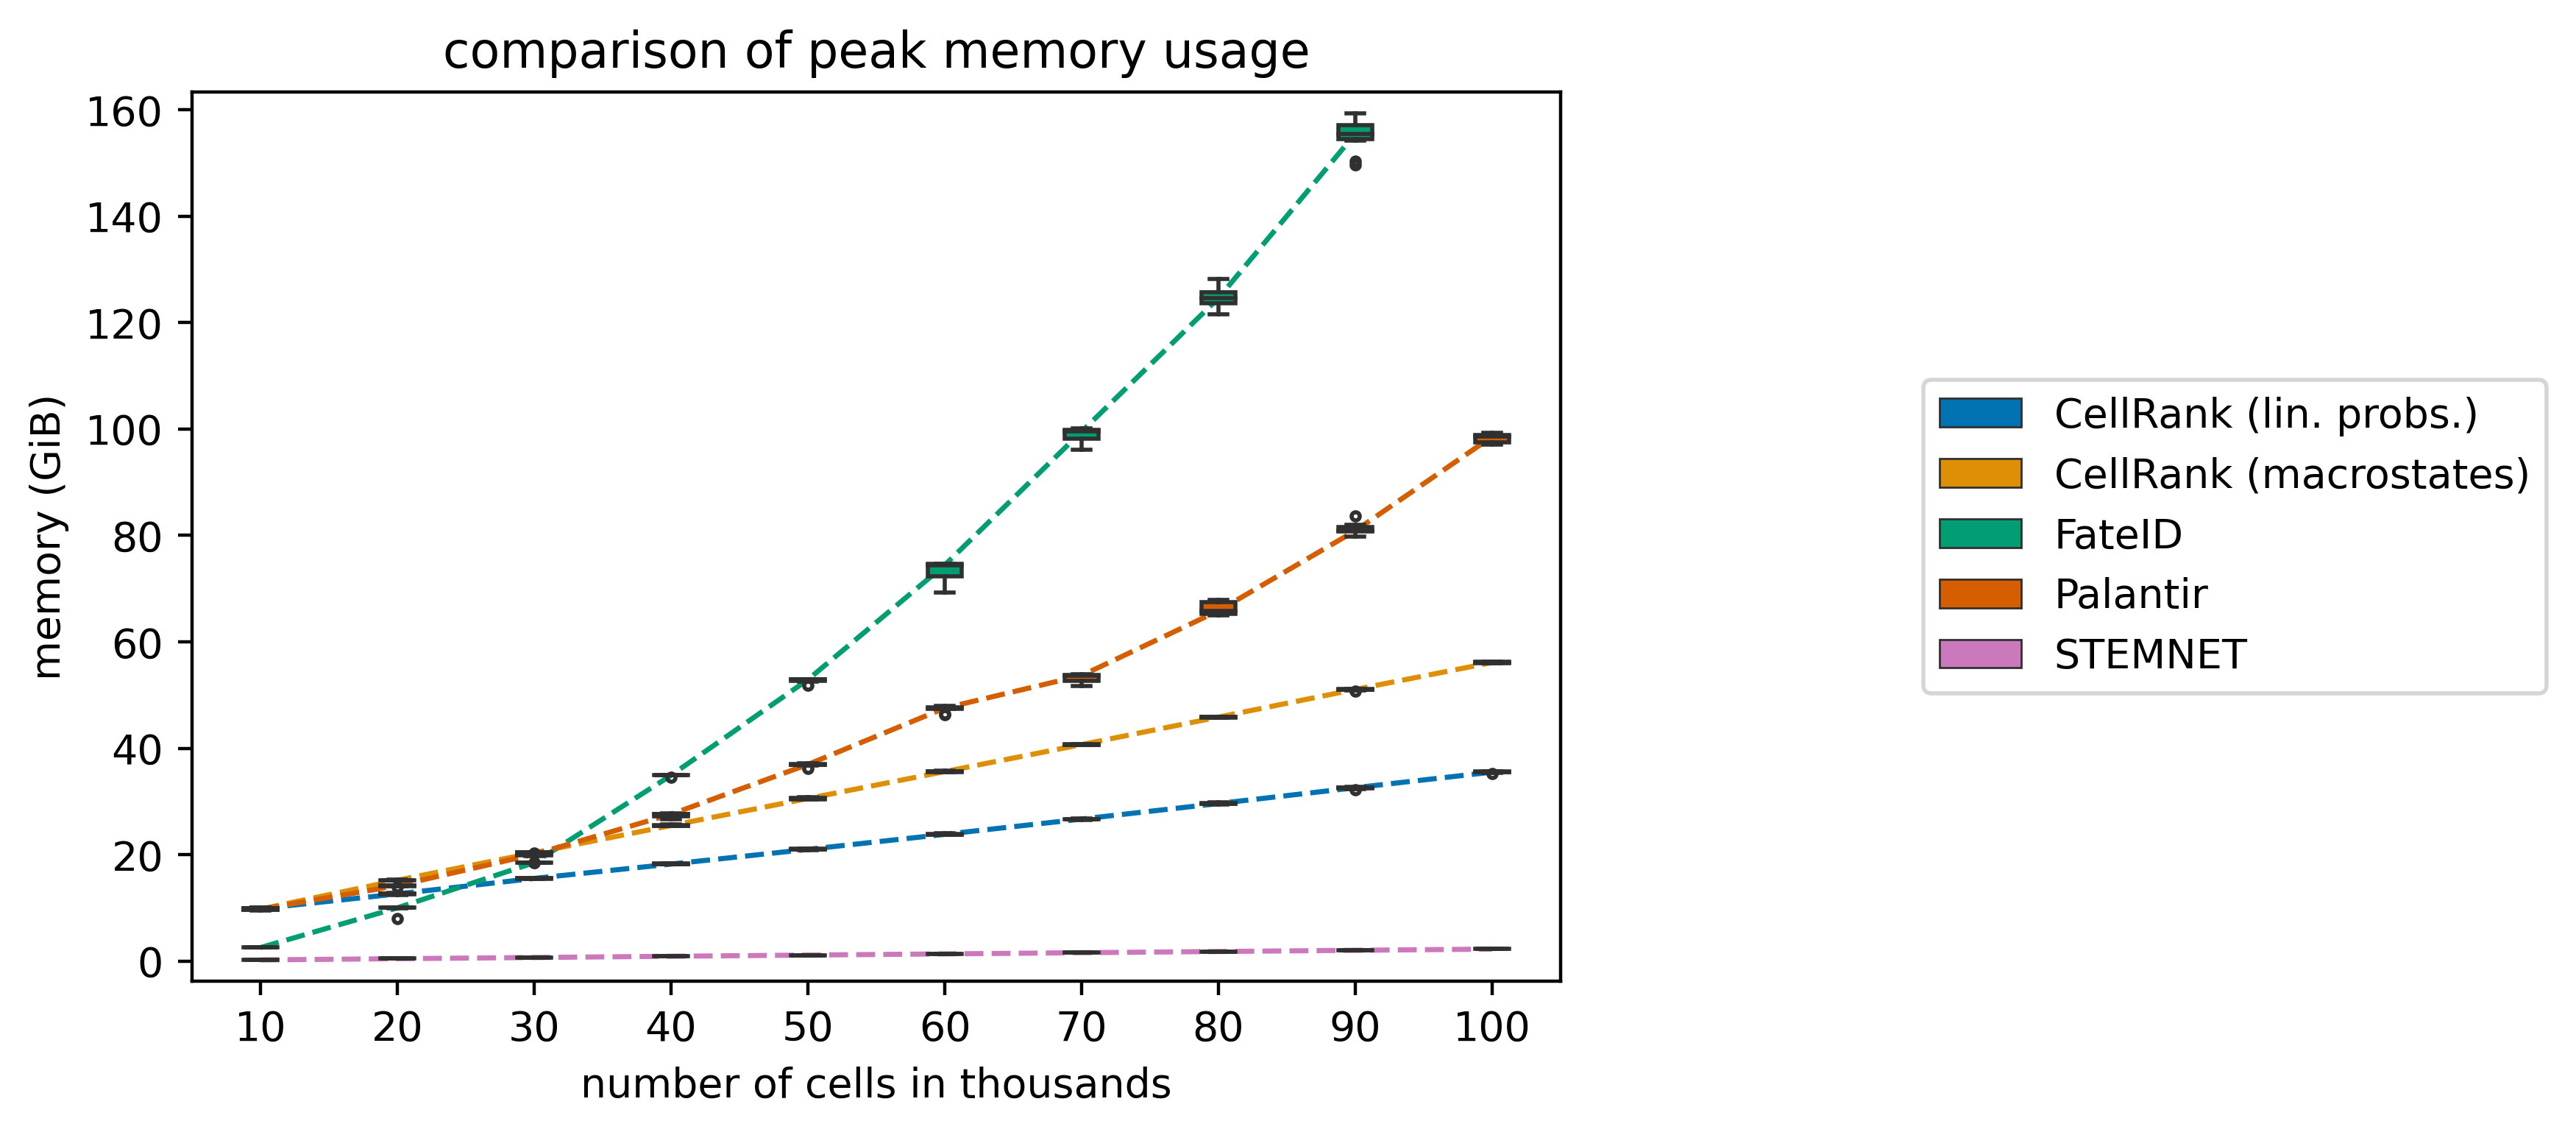

In [10]:
fig = plot(df)
fig.savefig(FIG_DIR / "suppl_fig_memory_benchmark" / "performance.pdf", bbox_inches='tight', transparent=True)

## Extract the data for the table creation

In [9]:
mean = df.groupby(alg).mean().T
mean.index.name = 'size'
mean.columns = [f"{c} mean" for c in mean.columns]

std = df.groupby(alg).std().T
std.index.name = 'size'
std.columns = [f"{c} std" for c in std.columns]

stats = pd.concat([mean, std], axis=1)
stats.index = stats.index.astype(int)
stats.index = np.array(stats.index / 1000, dtype='int')
stats.index.name = '#cells (thousands)'
stats = stats.round(2)

### Reorder the table columns

In [11]:
order = ['CellRank (macrostates)', 'CellRank (lin. probs.)', 'STEMNET', 'Palantir', 'FateID']
stats = stats[[f"{c} {s}" for c in order for s in ('mean', 'std')]]
stats

,CellRank (macrostates) mean,CellRank (macrostates) std,CellRank (lin. probs.) mean,CellRank (lin. probs.) std,STEMNET mean,STEMNET std,Palantir mean,Palantir std,FateID mean,FateID std
#cells (thousands),,,,,,,,,,
10,9.78,0.20,9.90,0.09,0.23,0.0,9.74,0.06,2.55,0.00
20,15.21,0.07,12.64,0.10,0.46,0.0,14.15,0.09,9.81,0.62
30,20.36,0.06,15.53,0.08,0.68,0.0,20.02,0.19,18.50,0.01
40,25.49,0.08,18.26,0.07,0.91,0.0,27.43,0.34,34.88,0.12
50,30.56,0.13,21.02,0.10,1.14,0.0,36.89,0.28,52.72,0.35
60,35.63,0.09,23.83,0.09,1.36,0.0,47.38,0.55,73.43,1.85
70,40.71,0.05,26.68,0.06,1.59,0.0,53.24,0.81,98.92,1.28
80,45.86,0.08,29.63,0.13,1.81,0.0,66.28,1.20,124.65,1.96
90,51.01,0.11,32.55,0.15,2.04,0.0,81.19,1.08,155.10,3.07


## Save the table

In [12]:
stats.to_csv(DATA_DIR / "benchmarking_results" / "suppl_tab_memory_benchmark" / "statistics.csv")